## 사전준비

In [ ]:
!pip install causalml

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold, cross_val_predict
from xgboost import XGBRegressor
from causalml.inference.meta import (
    BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor, BaseDRRegressor
)
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

### Estimation: Conditional Average Treatment Effect (CATE)

- 어떤 조건 X를 가진 사람에게 있어서 평균적인 처리 효과는 얼마나 될지를 의미.

$$
\text{CATE}(x) = \tau(x) = \mathbb{E}[Y(1) - Y(0) \mid X = x]
$$

## 데이터 구성

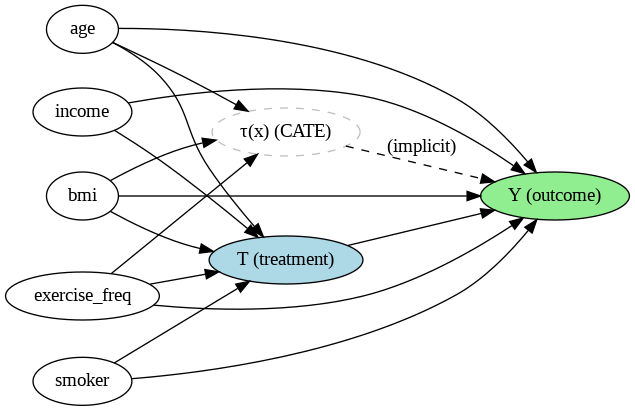

- 5개 변수 모두 (age, income, bmi, smoker, exercise_freq) → T (treatment)에 영향

- 5개 변수 모두 (age, income, bmi, smoker, exercise_freq) → Y (outcome)에도 영향

- T → Y (Treatment Effect)

- age, bmi, exercise_freq → $\tau(x)$ (CATE에 직접 관여하는 변수)

$$
\tau(x) = 2 + 0.02(30 - \text{age}) + 0.5 \cdot \mathbf{1}[\text{exercise} > 3] - 0.3 \cdot \text{bmi}
$$

- $\tau(x)$ → Y   (dashed)



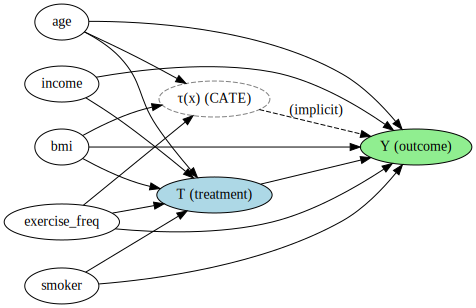

In [ ]:
from graphviz import Digraph

dot = Digraph(format='png')
dot.attr(rankdir='LR')

dot.node('age', 'age')
dot.node('income', 'income')
dot.node('bmi', 'bmi')
dot.node('smoker', 'smoker')
dot.node('exercise', 'exercise_freq')
dot.node('T', 'T (treatment)', style='filled', fillcolor='lightblue')
dot.node('Y', 'Y (outcome)', style='filled', fillcolor='lightgreen')
dot.node('tau', 'τ(x) (CATE)', style='dashed', color='gray')

for var in ['age', 'income', 'bmi', 'smoker', 'exercise']:
    dot.edge(var, 'T')
    dot.edge(var, 'Y')

dot.edge('T', 'Y')
dot.edge('age', 'tau')
dot.edge('bmi', 'tau')
dot.edge('exercise', 'tau')
dot.edge('tau', 'Y', style='dashed', label='(implicit)')

dot

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
n = 5000

# 공변량 생성
age = np.random.normal(40, 12, n)
income = np.random.normal(50000, 15000, n)
bmi = np.random.normal(25, 4, n)
smoker = np.random.binomial(1, 0.3, n)
exercise_freq = np.random.poisson(3, n)

X = np.column_stack([age, income, bmi, smoker, exercise_freq])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# logit propensity score (복잡도 추가)
logit_ps = (
    0.01 * bmi
    - 0.5 * smoker
    + 0.02 * age * smoker
    - 0.0001 * (income - 50000)**2
    + 0.05 * np.sin(bmi) * (exercise_freq > 2)
)
e = 1 / (1 + np.exp(-logit_ps))
e = np.clip(e, 0.1, 0.9)
T = np.random.binomial(1, e)

# 개별 CATE: 비선형적이고, 다변수 상호작용 포함 → S-Learner 불리
tau = (
    3 * np.sin(age / 6)                              # 큰 분산 유도
    + 0.8 * np.log1p(age ** 2) * (bmi > 30)          # 매우 비선형 + threshold
    - 0.4 * np.sqrt(bmi)
    + 0.5 * smoker * np.cos(exercise_freq)
    + 0.2 * np.tanh((age - 30) / 10) * (exercise_freq < 2)
    + 5.0 * np.sin(0.05 * age * bmi) * (smoker == 1) # 비선형 상호작용 추가
)

# 잠재 결과
mu0 = (
    50
    + 0.02 * income
    + 0.3 * bmi
    + 1.5 * (exercise_freq > 3).astype(float)
    + np.random.normal(0, 7, n)
)
mu1 = mu0 + tau
Y = mu0 * (1 - T) + mu1 * T

# 데이터프레임 구성
df = pd.DataFrame({
    "age": age,
    "income": income,
    "bmi": bmi,
    "smoker": smoker,
    "exercise_freq": exercise_freq,
    "treatment": T,
    "outcome": Y,
    "true_tau": tau,
    "pscore": e
})

df.head()

,age,income,bmi,smoker,exercise_freq,treatment,outcome,true_tau,pscore
0,45.960570,43643.604770,22.286021,0,2,0,935.169977,1.055465,0.1
1,38.340828,43198.788374,23.778002,0,4,0,924.049649,-1.630261,0.1
2,47.772262,23065.352411,22.610476,1,3,1,509.729116,-2.240219,0.1
3,58.276358,45048.647124,25.441672,0,3,0,967.888254,-2.869547,0.1
4,37.190160,60992.436227,29.788714,1,3,0,1281.219865,-7.508958,0.1


## 메타러너 개요

- Confounder가 있는 관측연구 (처리 할당에 confounder가 개입된 상황)에서 가장 일반적으로 사용할 수 있는 Baseline  
- ML을 기반으로 CATE를 추정하는 방법

    - **S-Learner**: 데이터 양이 적고 간단한 모델로 충분할 때 (하나의 모델로 처리와 대조를 모두 학습)

    - **T-Learner**: 처리군/대조군 간 분포 차이가 큰 경우 (각각 별도의 모델로 학습)

    - **X-Learner**: 처리군과 대조군의 비율이 매우 불균형할 때 (T-Learner 기반 + imputation 방식으로 보정)

    - **R-Learner**: 잠재적 confounding을 정규화해 제거하고 싶을 때 (Residualization 방식으로 학습)

    - **DR-Learner**: 처리 확률과 결과 예측 두 모델을 함께 사용해, 둘 중 하나만 정확해도 편향 없는 CATE 추정을 가능하게 하는 이중 강건(Doubly Robust) 추정법.

### S-Learner

### 동작 방식

#### **Stage 1: 단일 모델 학습**

- 공변량 $X$와 처리 여부 $T$를 하나의 입력으로 결합하여,
- 하나의 모델 $\hat{\mu}(X, T)$을 학습합니다.

$$
\hat{\mu}(x, t) \approx \mathbb{E}[Y \mid X = x, T = t]
$$

#### **Stage 2: CATE 추정**

- 동일한 입력 $x$에 대해 다음 두 값을 예측:
  - $\hat{\mu}(x, 1)$: 처리 받았을 때 예측 결과
  - $\hat{\mu}(x, 0)$: 처리 받지 않았을 때 예측 결과

$$
\widehat{\tau}(x) = \hat{\mu}(x, 1) - \hat{\mu}(x, 0)
$$

---

### 특징
  - 하나의 모델만 학습하므로 구현이 간단하고, 학습 효율이 좋음
  - **처리군과 대조군의 분포가 크게 다를 경우**, 하나의 모델로 양쪽을 모두 잘 설명하기 어려움
  - 특히 선형 모델을 사용할 경우, **다차원적인 이질성**을 포착하지 못하고 편향된 결과를 낼 수 있음

In [ ]:
from causalml.inference.meta import BaseSRegressor
from sklearn.ensemble import RandomForestRegressor

s_learner = BaseSRegressor(learner=XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1), control_name=0)
s_learner.fit(X, T, Y)

tau_hat_s = s_learner.predict(X)

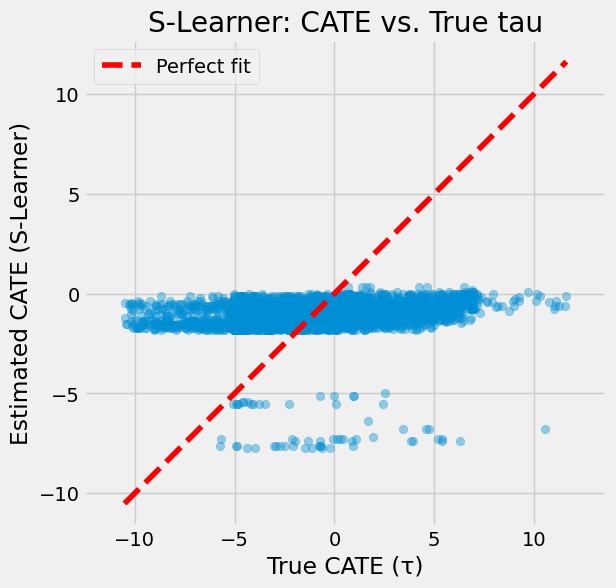

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(tau, tau_hat_s, alpha=0.4)
plt.plot([min(tau), max(tau)], [min(tau), max(tau)], 'r--', label='Perfect fit')
plt.xlabel('True CATE (τ)')
plt.ylabel('Estimated CATE (S-Learner)')
plt.title('S-Learner: CATE vs. True tau')
plt.legend()
plt.grid(True)
plt.xlim(-15, 5)
plt.ylim(-15, 5)
plt.axis('equal')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

mse_s = mean_squared_error(tau, tau_hat_s)
print(f"S-Learner MSE: {mse_s:.4f}")

S-Learner MSE: 11.1031


MSE는 낮은 값을 보이나, 그래프가 편향되게 그려진 이유는 처리군과 대조군의 분포가 크게 다르기 때문으로, 특히 exercise_freq와 smoke에서의 차이 때문인 것으로 분석됨.

- T=1 (treated) 그룹은 운동 횟수가 많은 사람들에 집중되어 있으며, 운동을 거의 안 하는 사람들(0~2)은 주로 T=0 (control)에 포함되어 있음

-  T=1 (treated) 그룹에서는 비흡연자 비율이 압도적으로 높고, T=0 (control) 그룹에서는 흡연자가 더 많음.

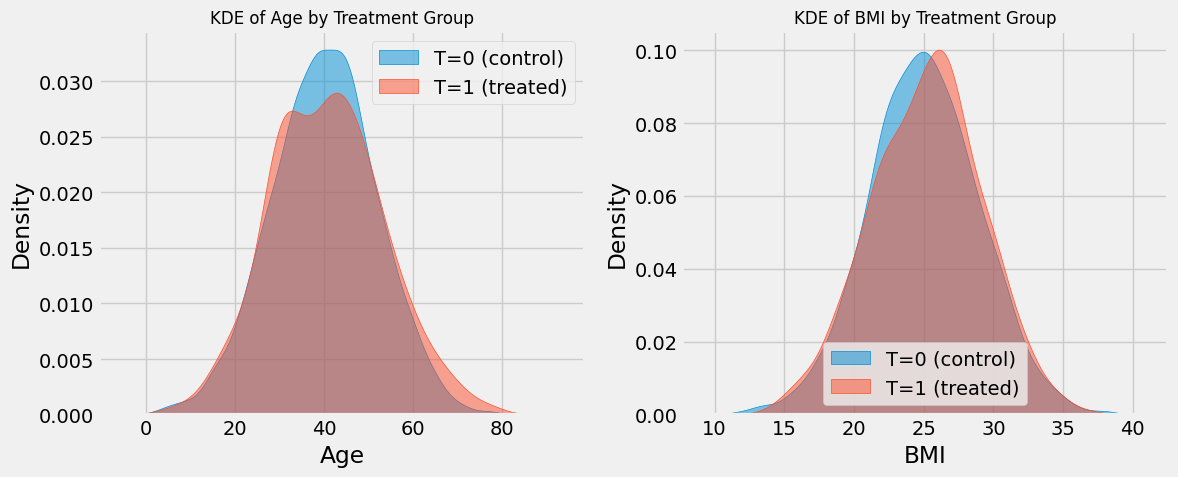

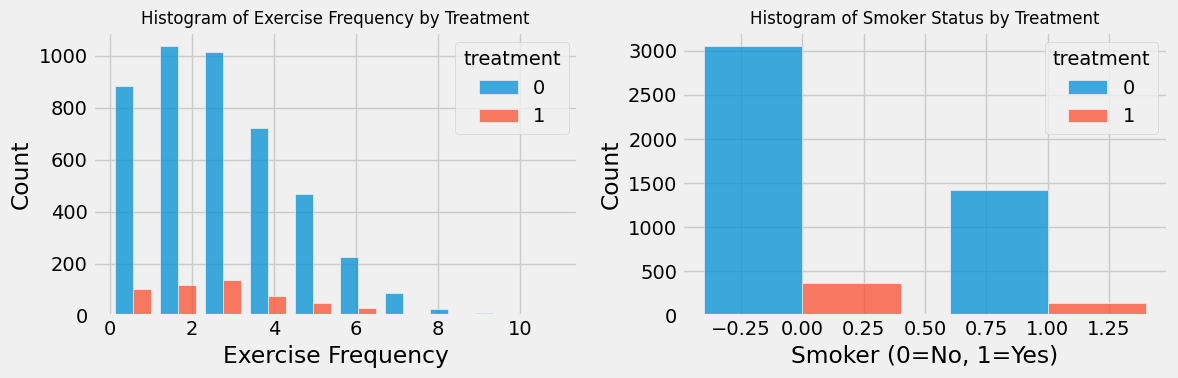

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Age
plt.subplot(1, 2, 1)
sns.kdeplot(data=df[df["treatment"]==0], x="age", label="T=0 (control)", fill=True, alpha=0.5)
sns.kdeplot(data=df[df["treatment"]==1], x="age", label="T=1 (treated)", fill=True, alpha=0.5)
plt.title("KDE of Age by Treatment Group", fontsize=12)
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend()

# BMI
plt.subplot(1, 2, 2)
sns.kdeplot(data=df[df["treatment"]==0], x="bmi", label="T=0 (control)", fill=True, alpha=0.5)
sns.kdeplot(data=df[df["treatment"]==1], x="bmi", label="T=1 (treated)", fill=True, alpha=0.5)
plt.title("KDE of BMI by Treatment Group", fontsize=12)
plt.xlabel("BMI")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()

# 이산형 변수: exercise_freq, smoker
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x="exercise_freq", hue="treatment", multiple="dodge", bins=10, shrink=0.8)
plt.title("Histogram of Exercise Frequency by Treatment", fontsize=12)
plt.xlabel("Exercise Frequency")

plt.subplot(1, 2, 2)
sns.histplot(data=df, x="smoker", hue="treatment", multiple="dodge", discrete=True, shrink=0.8)
plt.title("Histogram of Smoker Status by Treatment", fontsize=12)
plt.xlabel("Smoker (0=No, 1=Yes)")

plt.tight_layout()
plt.show()

### T-Learner

### 동작 방식

#### **Stage 1: 두 개의 모델 학습**

- 처리 여부 $T \in \{0, 1\}$에 따라 데이터를 분리하여,
  - **처리군(T=1)**에 대해: $\hat{\mu}_1(x) \approx \mathbb{E}[Y \mid X = x, T=1]$
  - **대조군(T=0)**에 대해: $\hat{\mu}_0(x) \approx \mathbb{E}[Y \mid X = x, T=0]$

#### **Stage 2: CATE 추정**

- 학습된 두 모델을 기반으로 다음처럼 CATE를 추정합니다:

$$
\widehat{\tau}(x) = \hat{\mu}_1(x) - \hat{\mu}_0(x)
$$

---

### 특징

- **처리군과 대조군의 분포가 다를 경우 효과적** : 각 모델이 자기 그룹의 분포에 맞춰 최적화되기 때문에 **Covariate shift**에 강한 구조

- 샘플 수가 적은 쪽의 모델 성능이 떨어질 수 있음 : 특히 **불균형한 T=0/T=1 비율**에서 문제가 될 수 있음

- 두 모델 간의 예측 차이를 기반으로 CATE를 추정하므로,  **추정 오류가 두 배로 누적될 위험**이 있음

In [ ]:
t_learner = BaseTRegressor(learner=XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1), control_name=0)

t_learner.fit(X, treatment=T, y=Y)

tau_hat_t, mu0_hat, mu1_hat = t_learner.predict(X, return_components=True)

In [ ]:
from sklearn.metrics import mean_squared_error

mse_t = mean_squared_error(df["true_tau"], tau_hat_t)
print(f"T-Learner MSE: {mse_t:.4f}")

T-Learner MSE: 288.2466


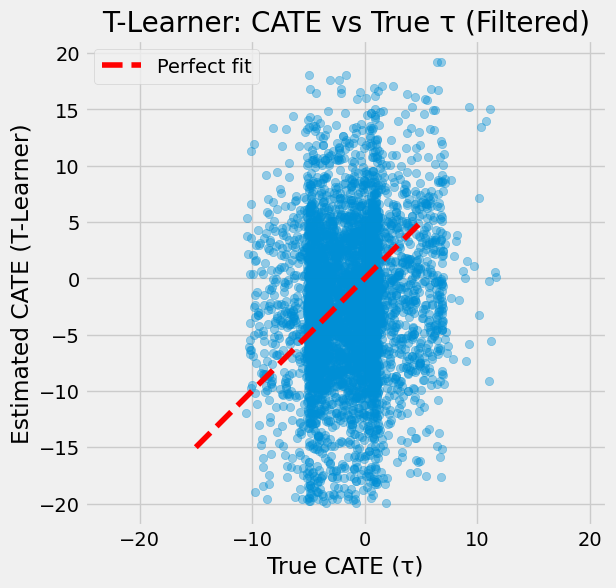

In [ ]:
tau_hat_t = np.array(tau_hat_t).flatten()
mask = (tau_hat_t > -20) & (tau_hat_t < 20)

plt.figure(figsize=(6, 6))
plt.scatter(tau[mask], tau_hat_t[mask], alpha=0.4)
plt.plot([-15, 5], [-15, 5], 'r--', label='Perfect fit')
plt.xlabel("True CATE (τ)")
plt.ylabel("Estimated CATE (T-Learner)")
plt.title("T-Learner: CATE vs True τ (Filtered)")
plt.legend()
plt.grid(True)
plt.xlim(-15, 5)
plt.ylim(-15, 5)
plt.axis("equal")
plt.show()

In [ ]:
tau_hat_t = np.array(tau_hat_t).flatten()
outlier = (tau_hat_t < -20) | (tau_hat_t > 20)
print(np.sum(outlier))

177


In [ ]:
treatment_counts = df["treatment"].value_counts(normalize=True)
print(treatment_counts)

treatment
0    0.8958
1    0.1042
Name: proportion, dtype: float64


필터링 이후의 T-Learner 결과를 보면, 일부 영역에서는 CATE 추정이 비교적 정확했으나, 전반적으로 예측 분산이 크고 이상치에 민감한 경향이 나타남. 이는 T-Learner가 $\mu_1$, $\mu_0$을 따로 학습하는 구조에서 발생할 수 있는 불안정성과 관련이 있으며, 특히 표본 수 (여기서는 T = 0일때의 경우)가 제한된 경우 효과적으로 일반화하지 못함을 보여줌.

### X-Learner

**X-Learner**는 개별 처치 효과 (CATE, $\tau(x)$) 추정을 위한 메타 러너(Meta-learner)로,  
**처치군과 대조군의 크기가 비대칭**인 경우에도 잘 작동.

### 동작방식

#### **Stage 1: 잠재 결과 모델 학습**
- 두 개의 예측 모델 $\hat{\mu}_0(x)$, $\hat{\mu}_1(x)$ 을 각각 학습하여:
  - $\hat{\mu}_0(x) \approx \mathbb{E}[Y(0) \mid X = x]$
  - $\hat{\mu}_1(x) \approx \mathbb{E}[Y(1) \mid X = x]$

---

#### **Stage 2: 보정된 처치 효과(imputed treatment effect) 생성**
- **처치군에서:**  $\tilde{\tau}_1 = Y_1 - \hat{\mu}_0(X_1)$

- **대조군에서:**  $\tilde{\tau}_0 = \hat{\mu}_1(X_0) - Y_0$

---

#### **Stage 3: CATE 보정 모델 학습**
- 각각을 예측하도록 두 개의 모델 학습:
  - 처치군 기반: $\hat{\tau}_1(x) \approx \mathbb{E}[\tilde{\tau}_1 \mid X=x]$
  - 대조군 기반: $\hat{\tau}_0(x) \approx \mathbb{E}[\tilde{\tau}_0 \mid X=x]$

- 최종 CATE 추정은 propensity score까지 활용하여 구성:
  $$
  \hat{\tau}(x) = (1 - e(x)) \cdot \hat{\tau}_1(x) + e(x) \cdot \hat{\tau}_0(x)
  $$
  여기서 $e(x) = P(T=1 \mid X=x)$ 는 **propensity score**

In [ ]:
x_learner = BaseXRegressor(learner=XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1), control_name=0)
x_learner.fit(X=X, treatment=T, y=Y)
tau_hat_x = np.array(x_learner.predict(X)).flatten()

In [ ]:
from sklearn.metrics import mean_squared_error

mse_x = mean_squared_error(tau, tau_hat_x)
print(f"X-Learner MSE: {mse_x:.4f}")

X-Learner MSE: 69.9162


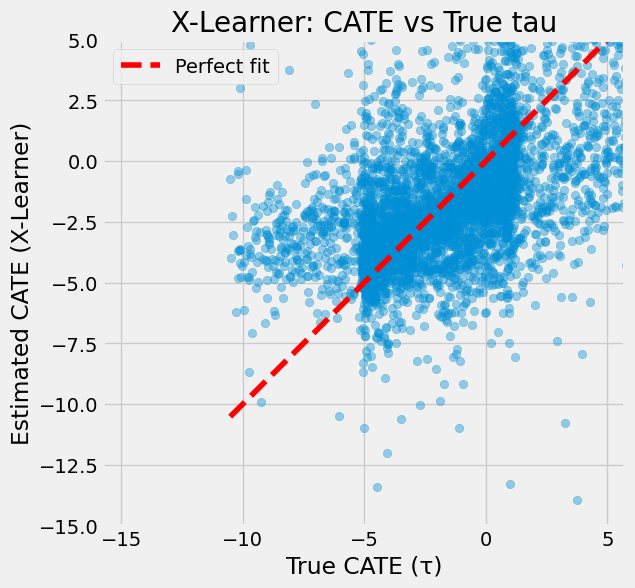

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(tau, tau_hat_x, alpha=0.4)
plt.plot([min(tau), max(tau)], [min(tau), max(tau)], 'r--', label='Perfect fit')
plt.xlabel("True CATE (τ)")
plt.ylabel("Estimated CATE (X-Learner)")
plt.title(f"X-Learner: CATE vs True tau")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.xlim(-15, 5)
plt.ylim(-15, 5)
plt.show()

이전 T learner보다 더 MSE가 작으며, 시각화 결과도 직선 경향성에 맞게 더 적합한 것을 확인할 수 있습니다.

### R-Learner

R-Learner는 Conditional Average Treatment Effect (CATE)를 추정하기 위한 메타러너 방법으로, 두 가지 nuisance function을 먼저 추정한 후, 잔차 기반의 회귀 모델을 학습하는 구조. 이 방식은 cross-fitting (또는 cross-validation)으로 overfitting을 방지하면서 regularization-friendly한 구조를 제공합니다.

### 동작방식

#### **Stage 1: Nuisance function 추정**
- $\hat{\mu}(X)$: 개별 관측치의 예측 결과값 (outcome regression)
- $\hat{e}(X)$: propensity score (treatment assignment 확률)

이 두 함수는 cross-validation 방식으로 out-of-fold 예측값을 사용하여 추정. 즉, i번째 샘플을 예측할 때는 해당 샘플이 포함되지 않은 fold로 학습된 모델을 사용함.

---

#### **Stage 2: R-Loss 최소화**

잔차 기반의 loss를 최소화하는 방법으로 CATE 추정

$$
\hat{\tau}(\cdot) = \arg\min_\tau \sum_{i=1}^{n} \left[ (Y_i - \hat{\mu}^{(-i)}(X_i)) - (T_i - \hat{e}^{(-i)}(X_i)) \cdot \tau(X_i) \right]^2
$$

### 특징

- Regularization-friendly: Lasso, Ridge, Random Forest 등 다양한 기법과 호환 가능
- Cross-fitting을 통해 bias를 줄이고 generalization 성능 향상

In [ ]:
r_learner = BaseRRegressor(learner=XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1), control_name=0)
r_learner.fit(X=X_scaled, treatment=T, y=Y)

tau_hat_r = r_learner.predict(X_scaled)

In [ ]:
from sklearn.metrics import mean_squared_error
tau_hat_r = tau_hat_r.flatten()
mse_r = mean_squared_error(tau, tau_hat_r)
print(f"R-Learner MSE: {mse_r:.4f}")

R-Learner MSE: 135.0474


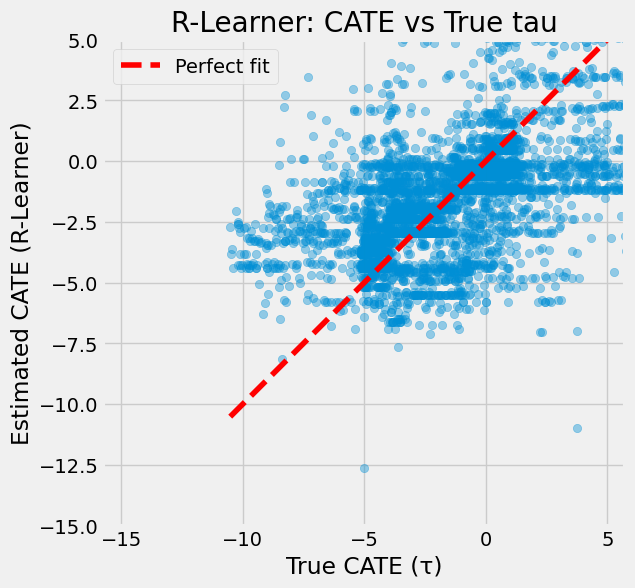

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(tau, tau_hat_r, alpha=0.4)
plt.plot([min(tau), max(tau)], [min(tau), max(tau)], 'r--', label='Perfect fit')
plt.xlabel("True CATE (τ)")
plt.ylabel("Estimated CATE (R-Learner)")
plt.title(f"R-Learner: CATE vs True tau")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.xlim(-15, 5)
plt.ylim(-15, 5)
plt.show()

전체적으로는 대각선과 일치하는 경향이나, 오차가 다소 존재 propensity score와 outcome 모두 out-of-fold로 학습해야 하고, noise가 많으면 성능에 영향. 정규화된 loss 기반 학습이라 추정 자체는 비교적 smooth하게 나온 것을 확인할 수 있음.

### Doubly Robust (DR) Learner

#### **Stage 1: 모델 학습 (분할된 데이터 사용)**

- 전체 데이터 $D$를 무작위로 **3개의 파티션** $D_1$, $D_2$, $D_3$로 나눕니다.
- 다음의 예측 모델들을 학습합니다:
  - **처리 확률(Propensity score)** 모델 $\hat{e}(x)$ using $D_1$
  - **결과 예측(Outcome regression)** 모델
    - $\hat{\mu}_1(x)$: 처리군 (treated) 결과 예측 모델 using $D_1$
    - $\hat{\mu}_0(x)$: 통제군 (control) 결과 예측 모델 using $D_1$

---

#### **Stage 2: Pseudo-outcome 계산 및 CATE 학습**

- Pseudo-outcome $\tilde{Y}_i$를 계산합니다:

  $$
  \tilde{Y}_i = \frac{W_i - \hat{e}(X_i)}{\hat{e}(X_i)(1 - \hat{e}(X_i))} \cdot \left( Y_i - \hat{\mu}_{W_i}(X_i) \right) + \hat{\mu}_1(X_i) - \hat{\mu}_0(X_i)
  $$

- 이 값을 타겟으로 사용하여 **CATE 모델 $\hat{\tau}(x)$**를 머신러닝으로 학습. (using $D_2$).

---

#### **Stage 3: 교차 반복 및 평균화**

- 위 과정을 **세 번 반복**합니다:
  - (1) $(D_1, D_2)$로 학습, $D_3$에 적용
  - (2) $(D_2, D_3)$로 학습, $D_1$에 적용
  - (3) $(D_3, D_1)$로 학습, $D_2$에 적용
- 최종 CATE 예측값은 세 번의 결과에 대한 **평균**이 됨.

---

#### 특징

- 추정값이 **propensity score와 outcome model 중 하나라도 잘 작동**하면 편향을 줄일 수 있는 **doubly robust** 특성을 가짐
- 교차 적합(cross-fitting)을 통해 과적합을 방지하고 일반화 성능을 높임

In [ ]:
dr_learner = BaseDRRegressor(learner=LinearRegression(), control_name=0) # 모델 단순화
dr_learner.fit(X=X_scaled, treatment=T, y=Y)
tau_hat_dr = np.array(dr_learner.predict(X_scaled)).flatten()

In [ ]:
mse_dr = mean_squared_error(tau, tau_hat_dr)
print(f"DR-Learner MSE: {mse_dr:.4f}")

DR-Learner MSE: 405.2657


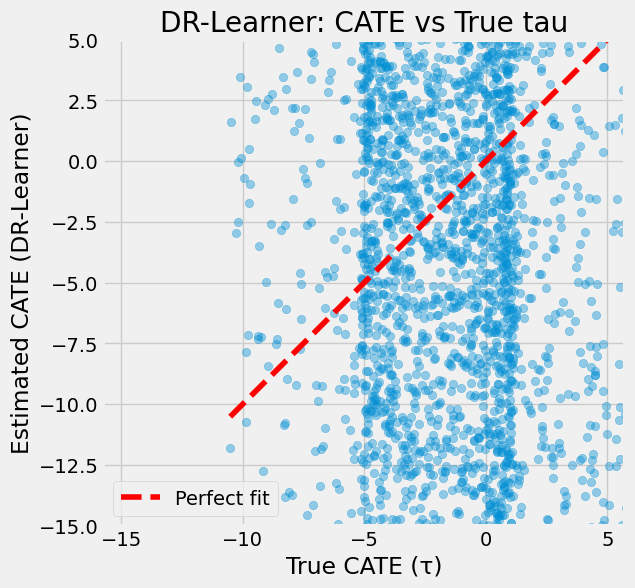

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(tau, tau_hat_dr, alpha=0.4)
plt.plot([min(tau), max(tau)], [min(tau), max(tau)], 'r--', label='Perfect fit')
plt.xlabel("True CATE (τ)")
plt.ylabel("Estimated CATE (DR-Learner)")
plt.title(f"DR-Learner: CATE vs True tau")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.xlim(-15, 5)
plt.ylim(-15, 5)
plt.show()

In [ ]:
tau_hat_dr = np.array(tau_hat_dr).flatten()
outlier = (tau_hat_dr < -20) | (tau_hat_dr > 20)
print(np.sum(outlier))

1434


DR-Learner는 구조상 민감한 식을 사용하므로, 간단한 시뮬레이션 환경에선 오히려 복잡한 학습기로 인해 불안정해질 수 있습니다. 모델 복잡도 제어 또는 pseudo-outcome 안정화가 필요합니다.

## 요약

비선형성과 강한 treatment heterogeneity 환경에서 **R-Learner와 X-Learner**가 상대적으로 안정적이며, S/T/DR-Learner는 구조적 제약이나 민감도로 인해 성능 저하를 겪는다.

- S-Learner MSE: 11.1031
- T-Learner MSE: 288.2466
- X-Learner MSE: 69.9162
- R-Learner MSE: 135.0474
- DR-Learner MSE: 405.2657

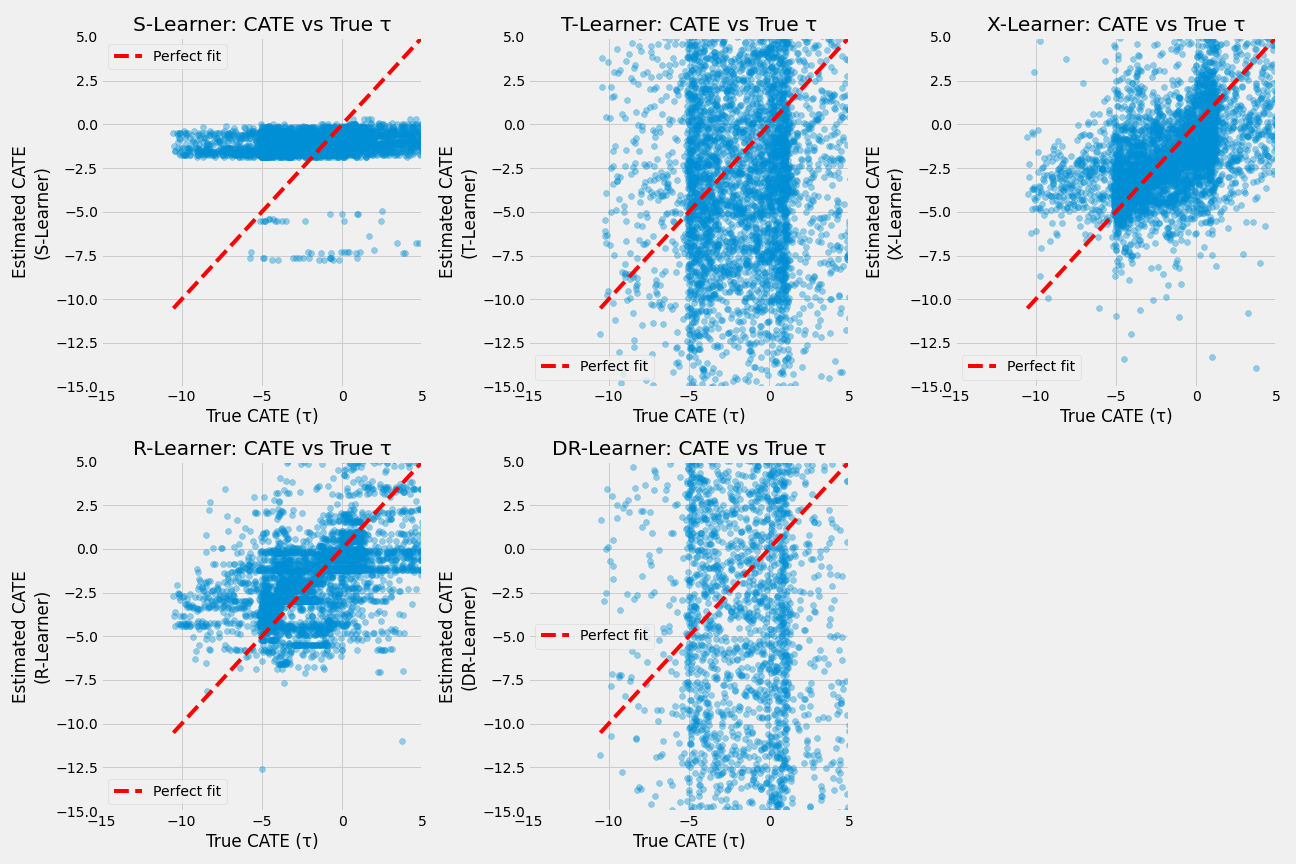

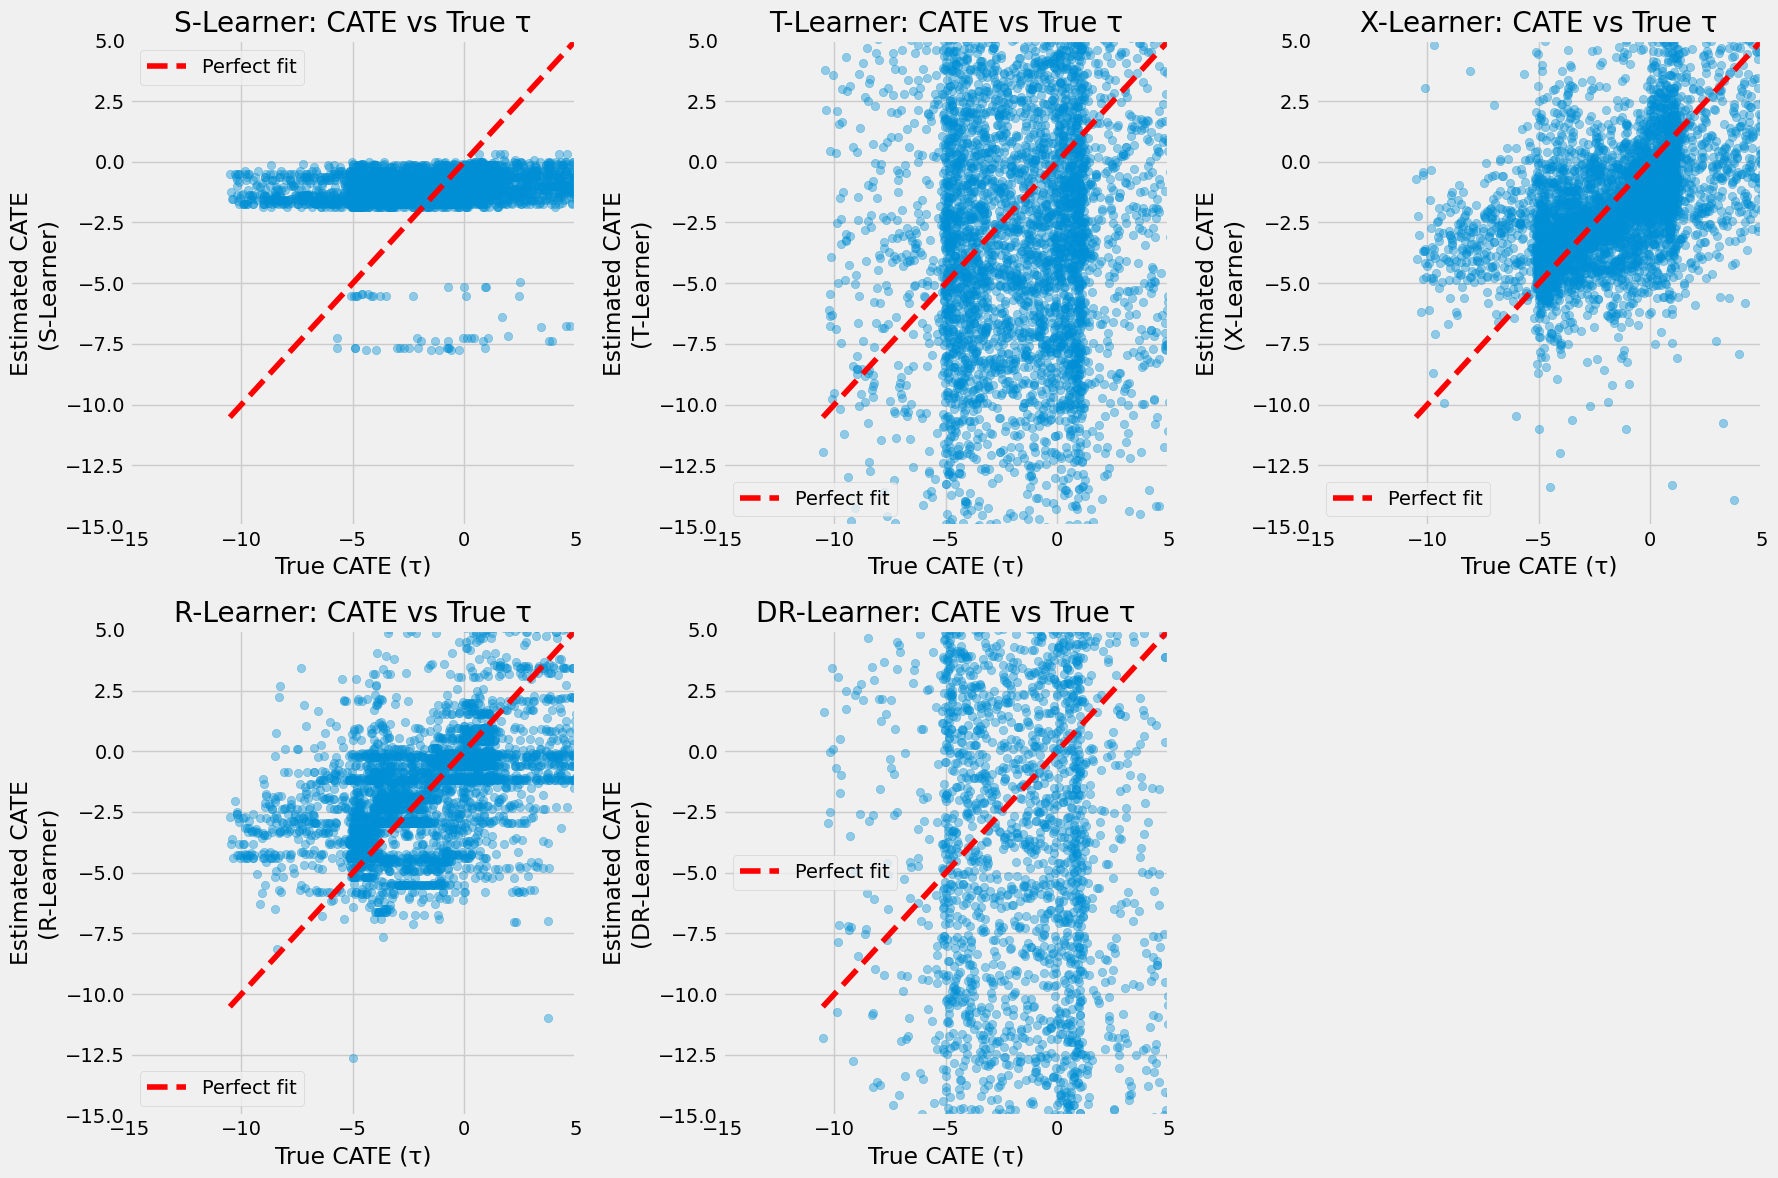

In [345]:
import warnings
warnings.filterwarnings("ignore")


learner_results = {
    "S-Learner": tau_hat_s,
    "T-Learner": tau_hat_t,
    "X-Learner": tau_hat_x,
    "R-Learner": tau_hat_r,
    "DR-Learner": tau_hat_dr
}


fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (name, tau_hat) in enumerate(learner_results.items()):
    tau_hat = np.array(tau_hat).flatten()
    ax = axes[idx]
    ax.scatter(tau, tau_hat, alpha=0.4)
    ax.plot([min(tau), max(tau)], [min(tau), max(tau)], 'r--', label='Perfect fit')
    ax.set_xlabel("True CATE (τ)")
    ax.set_ylabel(f"Estimated CATE\n({name})")
    ax.set_title(f"{name}: CATE vs True τ")
    ax.grid(True)
    ax.set_xlim(-15, 5)
    ax.set_ylim(-15, 5)
    ax.legend()

if len(learner_results) < len(axes):
    for j in range(len(learner_results), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("learner_comparison.png", dpi=72)
plt.show()

In [ ]:
for name, tau_hat in learner_results.items():
    tau_hat = np.array(tau_hat).flatten()
    mse = mean_squared_error(tau, tau_hat)
    print(f"{name} MSE: {mse:.4f}")

S-Learner MSE: 11.1031
T-Learner MSE: 288.2466
X-Learner MSE: 69.9162
R-Learner MSE: 135.0474
DR-Learner MSE: 405.2657


- S-Learner는 비선형 상호작용이나 개별적인 treatment heterogeneity를 충분히 포착하지 못하고, 평균적인 효과를 과소추정하는 경향을 보임. 그럼에도 불구하고 MSE가 낮은 이유는 모델이 보수적으로 평균에 수렴하면서도 극단적인 오차는 피했기 때문인 것으로 보임.

- T-Learner는 처치 집단과 비처치 집단을 각각 별도로 학습하므로, 표본 분산이 크거나 데이터가 sparsely distributed할 경우 불안정한 추정을 보임.

- X-Learner는 비교적 양호한 성능을 보이며, 특히 treatment assignment에 따른 imbalance를 어느 정도 보정해줍니다. 다만 여전히 극단적인 값에 대해 과소/과대 추정이 존재합니다.

- R-Learner는 baseline을 추정한 후 잔차를 학습하기 때문에, 상대적으로 안정적이며, $\tau$ 추정의 구조적 일관성이 관찰됩니다. 비선형성과 상호작용이 강한 환경에서도 비교적 잘 작동함을 보임.

- DR-Learner는 doubly robust 구조 덕분에 이론적으로는 bias에 강하지만, 실제로는 propensity score와 outcome model 모두의 민감성에 의해 pseudo-outcome의 분산이 매우 커질 수 있음을 보여줌.